# Introduction to numerical robotics

The aim of this notebook is to illustrate common robotic problems and motivate the need for the geometrical tools we are going to present in class. We will first try to solve these problems naively to convince ourselves that we need better tools to reliably achieve our objectives.

This notebook also provides a brief overview of [Pinocchio](https://stack-of-tasks.github.io/pinocchio/), a robotics library which we are going to use throughout the semester, in particular for the tutorials, as well as the meshcat visualiser that we will use for displaying our robots. We will briefly see the main methods used to manipulate the geometry model of a manipulator robot: set the configuration (posture), compute the position of an effector, check the collision or the distance to the obstacle. 

As such this notebook is an informal first step towards our objective of discovering how to make a robot move in a constrained the environment using iterative optimization methods.


In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


## Set up

We are going to work with the manipulator robot [UR5](https://www.universal-robots.com/products/ur5-robot/). The model of the robot is provided for you in the form of an XML-derived description file format called [urdf](http://wiki.ros.org/urdf/XML/model). You don't need to understand the format in details for this course.

We are going to import a few libraries / functions to set the scene accordingly.

(urdf, in the robotpkg_example_robot_data), the pinocchio python software, the python optimizers from scipy and for the display of the results: the gepetto viewer and the python matplotlib. We have that with this set of imports:

In [2]:
# %load tp0/generated/simple_path_planning_import
import pinocchio as pin #the pinocchio library
from utils.meshcat_viewer_wrapper import MeshcatVisualizer # the meshcat visualiser
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles,Target # helper function to load scene
from scipy.optimize import fmin_bfgs,fmin_slsqp # some optimisation routines from scipy
import time # the remaining libraries are python native
import numpy as np 
from numpy.linalg import norm
import matplotlib.pylab as plt 


For this class, we provide a helper method to load the robot model and create an obstacle field. The "reduced" parameter will be explained in a minute.

In [3]:
# %load tp0/generated/simple_path_planning_robot

robot = load_ur5_with_obstacles(reduced=True)


The next few lines initialize a 3D viewer.

In [6]:
# %load tp0/generated/simple_path_planning_viewer

viz = MeshcatVisualizer(robot)
viz.display(robot.q0)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


In [7]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

The scene should now be displayed in the viewer (check it). You can maintain left-click and move your mouse to change the camera orientation, and zoom using the mouse scroll wheel. Maitaining the right-click and moving around translates the camera while maintenain the orientation. The robot and the red obstacles are encoded in the robot object (we will not need to see in depth what is inside this object). 

You can display a new configuration of the robot with viz.display, which currently takes as input a numpy.array of dimension 2. These 2 values correspond to a desired joint angle value (in radians) for two articulations of the robot. You can play with the code below to change the configuration.

In [8]:
viz.display(np.array([1.,-1.5]))

We also set up a target, visualised as a green dot. The objective here is that the end of the robot reaches the target. You can change the target position by editing target.position, and display the new position with target.display().

In [9]:
# %load tp0/generated/simple_path_planning_target
target = Target(viz,position = np.array([.5,.5]))


## Using the robot model
The robot is originally a 6 degrees-of-freedom (DOF) manipulator. Yet to make the example simple, we will only use the joints 1 and 2. The model has simply been loaded with "frozen" extra joints, which will thus not appear in this notebook. Just load the model with reduced=False if you want to recover a model with full DOF. We are now given 3 functions that will help us to find a configuration of the robot that reaches the target.


The following function computes the position of the end effector (in 2d):

In [10]:
# %load tp0/generated/simple_path_planning_endef
def endef(q):
     '''Return the 2d position of the end effector given a configuration q.'''
     pin.framesForwardKinematics(robot.model,robot.data,q) # applies q to the robot model
     return robot.data.oMf[-1].translation[[0,2]] #extracts the position of the effector


The next function computes the distance between the end effector and the target.

In [11]:
# %load tp0/generated/simple_path_planning_dist
def dist(q):
     '''Given q, return the distance between the end effector and the target (2d).'''
     return norm(endef(q)-target.position)


The last function checks if the robot is in collision, and returns True if a collision is detected.

In [12]:
# %load tp0/generated/simple_path_planning_coll

def coll(q):
     '''Return true if in collision, false otherwise.'''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     return pin.computeCollisions(robot.collision_model,robot.collision_data,False)


## Random search of a valid configuration
The free space of the robot is defined as the set of configurations such that the robot is not in collision. Although a configuration only has 2 parameters in our example, we can't easily compute this space. However, we can determine if a configuration belongs to the free space or not.  We can thus randomly sample the configuration space until a free configuration is found:

In [13]:
# %load tp0/generated/simple_path_planning_qrand

def qrand(check=False):
    '''
    Return a random configuration. If check is True, this
    configuration is not is collision
    '''
    while True:
        q = np.random.rand(2)*6.4-3.2  # sample between -3.2 and +3.2.
        if not check or not coll(q): return q


In [14]:
viz.display(qrand(check=True))

Let's now find a valid configuration that is arbitrarily close to the target: sample until dist is small enough and coll is false (you may want to display the random trials inside the loop).

In [17]:
# %load tp0/generated/simple_path_planning_qrand_target
# Sample a random free configuration where dist is small enough.
def qrandTarget(threshold=5e-2, display=False):
     while True:
          q = qrand()
          if display:
               viz.display(q)
               time.sleep(1e-3)
          if not coll(q) and dist(q)<threshold:
               return q
viz.display(qrandTarget())


## From a random configuration to the target
Let' s now start from a random configuration. How can we find a path that bring the robot toward the target without touching the obstacles. Any idea?

In [20]:
# %do_not_load tp0/generated/simple_path_planning_random_descent

## Configuration space
Let's try to have a better look at the configuration space. In this case, it is easy, as it is dimension 2: we can sample it exhaustively and plot it in 2d. For that, let's introduce another function to compute the distance to collision:

In [21]:
# %load tp0/generated/simple_path_planning_colldist
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False): 0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance


Now, let's sample the configuration space and plot the distance-to-target and the distance-to-obstacle field as a function of the 2 angle values that determine the configuration of the robot (We use 1000 samples to spare your CPU, but you need at least 5x more for a good picture).

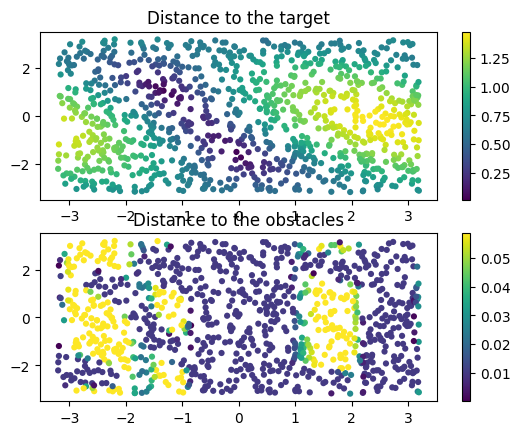

In [22]:
# %load tp0/generated/simple_path_planning_sample
def sampleSpace(nbSamples=500):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = qrand(False)
          if not coll(q):
               hfree.append( list(q.flat) + [ dist(q), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ dist(q), 1e-2 ])
     return hcol,hfree

def plotConfigurationSpace(hcol,hfree,markerSize=20):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.title("Distance to the target")
     plt.colorbar()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()

hcol,hfree = sampleSpace(1000)
plotConfigurationSpace(hcol,hfree)


You can try to match your representation of the free space of the robot with this plot. 
As an example, you can display on this plot some trajectories discovered during a random walk.

In [31]:
# %load tp0/generated/simple_path_planning_traj
qinit = np.array([-1.1, -3. ])
for i in range(100):
     traj = randomDescent(qinit)
     if dist(traj[-1])<5e-2:
          print('We found a good traj!')
          for q in traj:
            viz.display(q)
            time.sleep(1e-1)
          break
traj = np.array(traj)
### Chose trajectory end to be in [-pi,pi]
qend = (traj[-1]+np.pi) % (2*np.pi) - np.pi
### Take the entire trajectory it modulo 2 pi
traj += (qend-traj[-1])


We found a good traj!


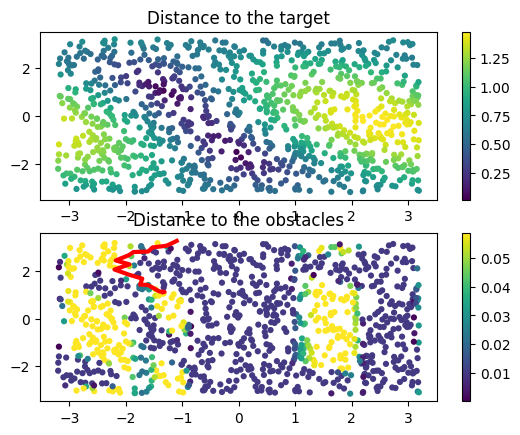

In [32]:
if 'traj' in locals():   ### Skip this cell if the previous block is not solved.
    plotConfigurationSpace(hcol,hfree)
    plt.plot(traj[:,0],traj[:,1],'r',lw=3)

## Optimize the distance under non-collision constraint
Finally, let's use one of the classic python solvers (from scipy) to search for a robot configuration that optimizes the distance to the target, under the constraint that the distance to collision is positive.
For that, we need to define a cost function (taking the robot configuration and return a scalar) and a constraint function (taking again the robot configuration and returning a scalar or a vector of scalar that should be positive). We additionally use the "callback" functionality of the solver, to render the robot configuration corresponding to the current value of the decision variable inside the solver algorithm.
We are going to use the "SLSQP" solver from scipy, which implements a "sequential quadratic program" algorithm and accepts constraints.

**See [the notebook about SciPy optimizers](appendix_scipy_optimizers.ipynb) for details.**

In [35]:
%do_not_load tp0/generated/simple_path_planning_optim

Look at the output of the solver. It always returns a variable value, but sometimes the algorithm fails being traped in an unfeasible region. Most of the time, the solver converges to a local minimum where the final distance to the target is nonzero. We can write a loop to call optimise until we reach the target.

In [39]:
%do_not_load tp0/generated/simple_path_planning_useit